1. Модифицировать реализацию KNN из методички так, чтобы больший вес получали наиболее близко расположенные объекты

______

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap
from sklearn import model_selection
from scipy.cluster import hierarchy
from sklearn.datasets import make_blobs
import random

In [4]:
class KNN:

    def __init__(self, X, y, X_test, k, distance_type='Euclidean', neighbor_weight=True):

        self.X = X
        self.y = y
        self.X_test = X_test
        self.k = k
        self.distance_type = distance_type
        self.neighbor_weight = neighbor_weight
        self.proba = []

    def get_distance(self, x1, x2):

        if self.distance_type == 'Euclidean':
            return np.sqrt(np.sum((x2-x1)**2))
        if self.distance_type == 'Manhatten':
            return (np.sum(np.abs(x2-x1)))

    def predict(self):

        answers = []
        proba = []
        for x in X_test:
            test_distances = []

            for i in range(len(self.X)):

                distance = self.get_distance(x, self.X[i])
                test_distances.append((distance, self.y[i]))
            classes = {class_item: 0 for class_item in set(self.y)}
            classes_weighted = {class_item: 0 for class_item in set(self.y)}

            for num, d in enumerate(sorted(test_distances)[0:k], 1):
                weight = 0.9**num if self.neighbor_weight else 1
                classes[d[1]] += 1
                classes_weighted[d[1]] += weight
            proba.append([classes[el] / k for el in sorted(classes)])
            answers.append(
                sorted(classes_weighted, key=classes_weighted.get)[-1])
        self.proba = np.array(proba)

        return np.array(answers)

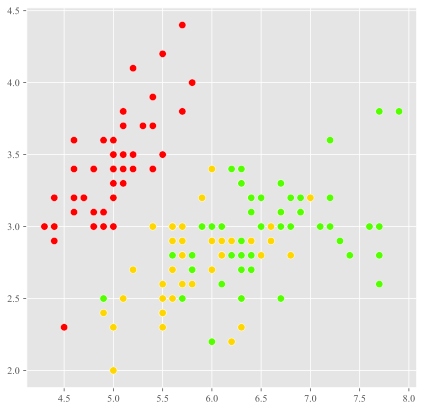

In [5]:
# загрузим данные
X, y = load_iris(return_X_y=True)
X = X[:, :2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.35, random_state=1)

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='prism', edgecolors="white", s=55)

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [7]:
# проверим работу алгоритма KNN без использования весов соседей
accuracy_1 = []
for k in range(1, 20):
    knn_class = KNN(X_train, y_train, X_test, k, neighbor_weight=False)
    y_pred = knn_class.predict()
    accuracy_1.append(accuracy(y_pred, y_test))

In [8]:
# проверим работу алгоритма KNN c приданием весов соседям
accuracy_2 = []
for k in range(1, 20):
    knn_class_2 = KNN(X_train, y_train, X_test, k, neighbor_weight=True)
    y_pred = knn_class_2.predict()
    accuracy_2.append(accuracy(y_pred, y_test))

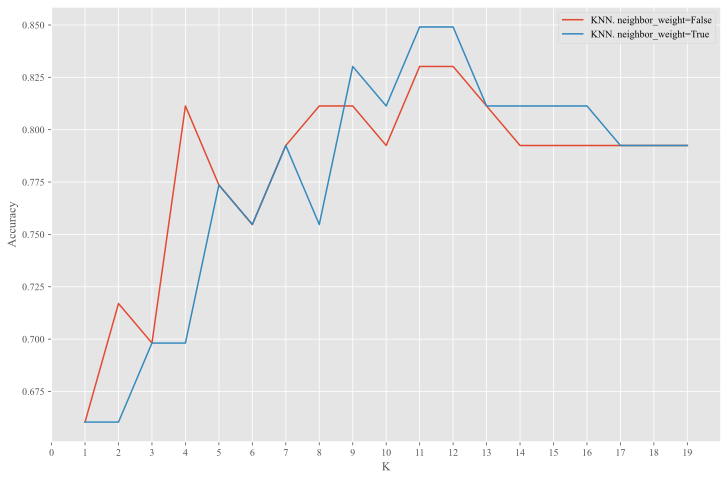

In [9]:
plt.figure(figsize=(12, 8))
x = list(range(1, 20))
plt.xlim(0, 20)
plt.xticks(np.arange(0, 20, step=1))
plt.plot(x, accuracy_1, label='KNN. neighbor_weight=False')
plt.plot(x, accuracy_2, label='KNN. neighbor_weight=True')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

*****

2. Реализовать иерархическую кластеризацию с любой из межкластерных метрик, кроме рассмотренной на вебинаре(Average Linkage Distance). Межкластерные метрики(Intercuster Distance) находятся здесь: https://www.geeksforgeeks.org/ml-intercluster-and-intracluster-distance/

In [10]:
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2-x1)**2))

In [11]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}

    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]

    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)

        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()

        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(
                classes[classification], axis=0)

        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False

        # если все смещения меньше минимального, останавливаем алгоритм
        if optimal:
            break

    return old_centroids, classes

In [12]:
X, y = make_blobs(n_samples=100, random_state=1)

In [13]:
max_iterations = 25

centroids, clusters = kmeans(X, 4, max_iterations, min_distance=1e-4)

In [14]:
def dist_matrix(clusters):
    matrix = np.zeros((len(clusters), len(clusters)))
    for i, u in enumerate(clusters):
        for j, v in enumerate(clusters[i+1:], start=i+1):
            matrix[[i, j], [j, i]] = distance_metric(u, v)
    return matrix


def indexes_to_combine(dist_matrix):
    min_el = dist_matrix[np.triu_indices(dist_matrix.shape[0], 1)].min()
    return np.argwhere(dist_matrix == min_el)[0], min_el


def exclude_clusters(i, j, dist_matrix):
    mask = np.ones(dist_matrix.shape[0], dtype=bool)
    mask[i] = False
    mask[j] = False
    return dist_matrix[mask, :][:, mask]


def merge_clusters(i, j, clusters):
    new_cluster = clusters[i]+clusters[j]
    return new_cluster, [c for k, c in enumerate(clusters) if not k in [i, j]]


def include_cluster(dist_mat, old_clusters, new_cluster):
    new_col = np.array([distance_metric(c, new_cluster)
                        for c in old_clusters])[:, np.newaxis]
    dist_mat = np.concatenate([dist_mat, new_col], axis=1)
    new_row = np.concatenate([new_col.flatten(), [0]])[np.newaxis, :]
    dist_mat = np.concatenate([dist_mat, new_row], axis=0)
    return dist_mat


def hierarchy_clustering(cluster_list):
    cluster_list = cluster_list[:]
    dist_mat = dist_matrix(cluster_list)
    cluster_numbers = list(range(len(cluster_list)))
    z = []
    new_num = len(cluster_list)
    while len(cluster_list) > 1:
        [i, j], min_val = indexes_to_combine(dist_mat)
        if i == j:
            continue
        dist_mat = exclude_clusters(i, j, dist_mat)
        new_cluster, old_clusters = merge_clusters(i, j, cluster_list)
        dist_mat = include_cluster(dist_mat, old_clusters, new_cluster)
        z.append([cluster_numbers[i], cluster_numbers[j],
                  min_val, len(new_cluster)])
        print([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
        cluster_list = old_clusters+[new_cluster]
        cluster_numbers = [n for k, n in enumerate(
            cluster_numbers) if not k in [i, j]]+[new_num]
        new_num += 1
    return z

Distance metric - Complete Linkage Distance
[2, 3, 3.916829600863291, 815]
[1, 4, 10.124508111718242, 1650]
[0, 5, 18.086392197542647, 2500]
Distance metric - Average Linkage Distance
[2, 3, 1.8485021569643154, 815]
[1, 4, 5.622278928346278, 1650]
[0, 5, 12.75837408805402, 2500]


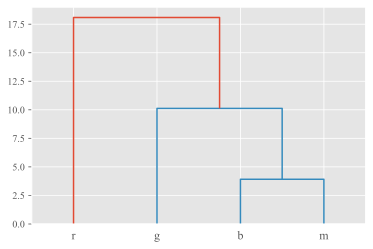

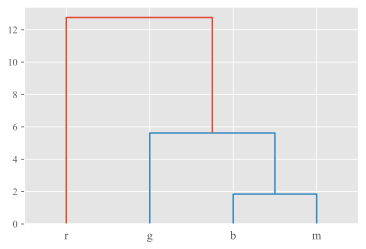

In [15]:
for dis_type in ['max', 'mean']:

    def distance_metric(u_clast, v_clast, dis_type=dis_type):
        if dis_type == 'mean':
            return sum((e_metrics(x, y) for x in u_clast for y in v_clast))/(len(u_clast)*len(v_clast))
        if dis_type == 'max':
            return max((e_metrics(x, y) for x in u_clast for y in v_clast))

    if dis_type == 'mean':
        print('Distance metric - Average Linkage Distance')
    if dis_type == 'max':
        print('Distance metric - Complete Linkage Distance')
    

    cluster_keys = list(clusters.keys())
    cluster_data = [clusters[k] for k in cluster_keys]
    Z = hierarchy_clustering(cluster_data)
    fig, ax = plt.subplots()
    hierarchy.dendrogram(Z, labels=['r', 'g', 'b', 'm']);
    print('='*100)